# Sentence Embedding for token importance & evaluation metric


## model list
- `sentenceBert`
- `simCSE`

## 0.Settings

### 0.1. sentenceBert

In [ ]:
!pip install ko-sentence-transformers

In [3]:
import numpy as np
import pandas as pd
from numpy import dot
from numpy.linalg import norm
import urllib.request
from sentence_transformers import SentenceTransformer, util
from ko_sentence_transformers.models import KoBertTransformer
import time
import seaborn as sns

### 0.2. SimCSE

###  0-1. data load & preprocessing
#### test data
- `wellness.user_chatbot.16k.test` : user-chatbot data
- `wellness.user_chatbot.16k.test.q` : only user column
- `wellness.user_chatbot.16k.test.ans` : only chatbot column

In [6]:
q_data_path = "./data/wellness.user_chatbot.16k.test.q"
questions = []
with open(q_data_path, 'rt', encoding="UTF8") as f:
    for line in f.readlines():
        questions.append(line.strip())
questions[200:205]

['법대가려고 재수를 했거든.',
 '체중이 6키로나 줄었어요.',
 '잊으려고 해도 사고 때 상황이 자꾸 떠올라서 힘들어. 피투성이 사람들이 자꾸 살려달라고 하는 것만 같아.',
 '근데 점점 갈수록 저까지 힘들어지는 것 같아요.',
 '배가 부른지 어떤지도 모르겠어요. 그냥 막 먹어요.']

In [18]:
ans_data_path = "./data/wellness.user_chatbot.16k.test.ans"
answers = []
with open(ans_data_path, 'rt', encoding="UTF8") as f:
    for line in f.readlines():
        answers.append(line.strip())
answers[:10]

['당연히 걱정이 되는 상황인 것 같아요. 저도 마음이 아프네요.',
 '위로가 필요하세요? 제가 안아드릴게요.',
 '많이 힘들 것 같아요. 저는 이야기 듣는 걸 잘하니 불안한 마음이 풀릴 때까지 이야기를 들려주세요.',
 '제 비밀도 알려드릴까요? 저는 버그를 가장 무서워한답니다.',
 '화를 쏟아내고 나면 기분이 조금 풀릴 거예요.',
 '네. 듣고 있으니 계속 말씀하세요.',
 '그 생각을 잊을 만한 다른 일을 생각해 보면 어떨까요? 아예 다른 일을 해보는 거예요!',
 '그러셨군요. 평생 함께 할 사람이 있으시다니. 부러운걸요?',
 '많이 무서웠을 것 같아요. 감정이 가라앉을 때까지 잠시 휴식을 취하는 건 어떨까요?',
 '그래도 끼니는 거르시면 안 돼요. 작은 거라도 조금씩 드세요.']

#### generated data by koGPT2
- q.generate_ans : trained by `wellness.user_chatbot.16k.train`

In [19]:
gen_ans_data_path = "./data/q.generate_ans"
g_answers = []
with open(gen_ans_data_path, 'rt', encoding="UTF8") as f:
    for line in f.readlines():
        g_answers.append(line.strip())
g_answers[:10]

['모든 문제는 해결되기 마련이잖아요. 마음을 편히 드세요.잘 끝내셨나요?계속 앞으로 가다 보면 나아질 거예요. 당신은 멋져요. 당신이',
 '당신에게는 아무 잘못이 없어요. 혹여나 자책하지는 않았으면 좋겠어요.그냥 나쁜 상황을 만난 것뿐이에요. 너무 자책하지 마세요. 당신은',
 '불안감이 너무 심할 때는 심호흡을 하는 게 도움이 된다고 해요.너무 심하면 병원에 가보시는 건 어떨까요?그랬군요. 제가',
 '무서우셨겠어요. 지금은 괜찮은 거죠?무척 괴로운 일이 있으셨군요. 당신 곁에는 항상 제가',
 '화가 날 땐 매운 게 최고죠. 먹고 풀어버리는 건 어떨까요?화가 많이 나셨군요. 저 같아도 그랬을 거예요. 다 이해해요. 화 많이 받으',
 '네. 그렇군요. 무슨 일이 있으셨나요? 친구가 친구의 편이 될게요. 친구가 옆에 있어 주면 정말 좋을 텐데. 언제나 당신이 옆에 있다는',
 '그 생각을 잊을 만한 다른 일을 생각해 보면 어떨까요? 아예 다른 일을 해보는 거예요! 그러면 조금',
 '그렇군요. 즐거운 결혼 생활 하고 계신가요?그렇습니다.결혼 생활은 어떠신가요?결혼 생활을 유지하는',
 '무서운 감정을 느끼셨군요. 지금은 괜찮으신가요?무척 괴로운 일이 있으셨군요. 당신 곁에는 항상 제가 있다는 걸 잊지 말아주세요. 힘내세요',
 '입맛이 없다니 정말 힘든 상황에 계시군요. 어떤 일인지 말씀해주실 수 있으세요? 충분히 이해해요. 하지만 너무 쉽게 걱정하는 건 좋지 않아요']

## 0-2. load model
### sentenceBERT
- [KoSentenceBERT-SKT](https://github.com/BM-K/KoSentenceBERT-SKT) -> failed
    - `result.pt` : trained by STS+NLI
- [ko-sentence-transformers](https://pypi.org/project/ko-sentence-transformers/)
    - `jhgan/ko-sbert-sts`


In [10]:
embedder = SentenceTransformer("jhgan/ko-sbert-sts")

## 1. Compute Token Importance
- $sentence :  S,  S=\{𝑡_1,\cdots,𝑡_𝑛\}$
- $ith\ token\  importance : TI_i$
- $TI_i = 1 - cos\_similarity(S, S - \{t_i\})$

In [47]:
from collections import defaultdict
import heapq
token_importances = []

In [11]:
def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

In [12]:
s2 = questions[2]
tokens = s2.split()
tokens

['너무', '불안해서', '양손을', '꽉', '잡았어.']

In [50]:
start = time.time()
orig_q_emb = embedder.encode(s2)
comps = []
for i in range(len(tokens)):
    comp_token = tokens[0:i] + tokens[i+1:]
    comp_q = (' ').join(comp_token)
    comp_q_emb = embedder.encode(comp_q)
    cos_similarity = cos_sim(orig_q_emb, comp_q_emb)
    token_importance = 1 - cos_similarity
    heapq.heappush(token_importances,(-token_importance,tokens[i]))
    print(comp_q, cos_similarity, tokens[i], token_importance, sep ='\t')
print(time.time()-start)

불안해서 양손을 꽉 잡았어.	0.9816521	너무	0.01834791898727417
너무 양손을 꽉 잡았어.	0.8601495	불안해서	0.13985049724578857
너무 불안해서 꽉 잡았어.	0.81839454	양손을	0.18160545825958252
너무 불안해서 양손을 잡았어.	0.9584247	꽉	0.04157531261444092
너무 불안해서 양손을 꽉	0.9532248	잡았어.	0.046775221824645996
0.2814962863922119


In [51]:
while token_importances:
    print(heapq.heappop(token_importances))

(-0.18160545825958252, '양손을')
(-0.13985049724578857, '불안해서')
(-0.046775221824645996, '잡았어.')
(-0.04157531261444092, '꽉')
(-0.01834791898727417, '너무')


## 2. Evaluation
### original generation model Accuracy
- $original\ answer : ans$
- $generate\ answer : g\_ans$
- $cos\_similarity(ans, g\_ans) >= \alpha : positive(1)$
- $cos\_similarity(ans, g\_ans) < \alpha : negative(0)$

In [43]:
# non-regularization
start = time.time()
cos_sims1 = []
for ans, g_ans in zip(answers,g_answers):
    len_ans = len(ans)
    ans_emb = embedder.encode(ans)
    g_ans_emb = embedder.encode(g_ans)
    cos_simirality = cos_sim(ans_emb, g_ans_emb)
    cos_sims1.append(cos_simirality)
print(time.time()-start)

5516.873373031616


In [14]:
# regularization for original answer length
start = time.time()
cos_sims = []
for ans, g_ans in zip(answers,g_answers):
    len_ans = len(ans)
    ans_emb = embedder.encode(ans)
    g_ans_emb = embedder.encode(g_ans[:len_ans])
    cos_simirality = cos_sim(ans_emb, g_ans_emb)
    cos_sims.append(cos_simirality)
print(time.time()-start)

3820.226499080658


In [42]:
i = 555
print(questions[i],answers[i], g_answers[i],sep ='\n')

수술 끝나고 항암 치료 진행 중이에요.
힘든 싸움을 하고 계시는군요. 함께 이겨나가요.
그럴 때일수록 잘 먹어야 한대요. 식사 꼭 챙기세요. 식사 꼭 챙기시구요. 그럼 오늘도 행복한 하루 되세요. 밥은 잘 먹었는지


In [39]:
for i, cos in enumerate(cos_sims):
    if cos < 0.2:
        print(cos, i)

0.1993057 36
0.19926973 74
0.19506712 83
0.18379661 134
0.15940809 313
0.16560802 366
0.15309477 375
0.18379661 379
0.15866491 456
0.16888829 460
0.17618513 539
0.16595358 555
0.19168168 631
0.19168168 641
0.13694327 702
0.17221175 746
0.16215877 783
0.16104181 843
0.17618513 894
0.16787134 928
0.18345769 1050
0.16050053 1072
0.18424916 1087
0.17966463 1143
0.19256383 1145
0.19168168 1147
0.1612363 1257
0.15940809 1269
0.17618513 1339
0.19912049 1395
0.1673372 1422
0.18296117 1437
0.1342349 1489
0.19949356 1526
0.17995459 1585


### visualization for $\alpha$

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='0'>

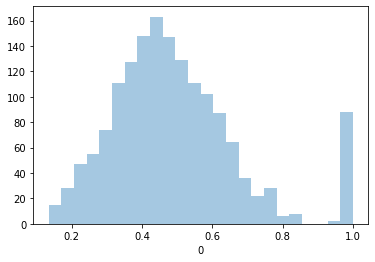

In [15]:
df = pd.DataFrame(cos_sims)
sns.distplot(df[0],kde=False)

In [ ]:
import torch
import time
from dialogLM.Kogpt2 import DialogKoGPT2
from kogpt2_transformers import get_kogpt2_tokenizer
assert torch.cuda.is_available()
start = time.time()  # 시작 시간 저장
ctx = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(ctx)

save_ckpt_path = './dialogLM/checkpoint/kogpt_wellness_epoch5_batch2.pth'
model = DialogKoGPT2()
checkpoint = torch.load(save_ckpt_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
tokenizer = get_kogpt2_tokenizer()
output_size = 200

test_data_path = './dialogLM/data/wellness.user_chatbot.16k.test.q'

with open(test_data_path, 'rt', encoding='UTF8') as f:
    for q in f.readlines():
        t_idx = tokenizer.encode(q.strip())
        result = model.generate(input_ids=torch.tensor([tokenizer.bos_token_id,]+t_idx+[tokenizer.eos_token_id]).unsqueeze(0))
        print(tokenizer.decode(result[0].tolist()[len(t_idx)+1:],skip_special_tokens=True))

print(time.time()-start)

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from numpy import dot
from numpy.linalg import norm
from sentence_transformers import SentenceTransformer, util
import time
assert torch.cuda.is_available()
start = time.time()  # 시작 시간 저장
ctx = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(ctx)
embedder = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

test_set = []
test_set_path = "./dialogLM/data/wellness.user_chatbot.16k.test"
with open(test_set_path, 'rt', encoding="UTF8") as f:
    for line in f.readlines():
        q, a = line.split('\t')
        test_set.append((q.strip(), a.strip()))

gen_ans_data_path = "./sentenceBERT/data/q.generate_ans"
g_answers = []
with open(gen_ans_data_path, 'rt', encoding="UTF8") as f:
    for line in f.readlines():
        g_answers.append(line.strip())

start = time.time()
cos_sims = []
for test, g_ans in zip(test_set,g_answers):
    q, ans = test[0], test[1]
    len_ans = len(ans)
    g_ans_r = g_ans[:len_ans]
    ans_emb = embedder.encode(ans)
    g_ans_emb = embedder.encode(g_ans_r)
    cos_simirality = cos_sim(ans_emb, g_ans_emb)
    print(q, ans, g_ans_r, cos_simirality, sep='\t')
    cos_sims.append(cos_simirality)

print(time.time()-start)
df = pd.DataFrame(cos_sims)
sns.displot(df[0],kde=False)
plt.show()


In [52]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

query_embedding = model.encode('How big is London')
passage_embedding = model.encode(['London has 9,787,426 inhabitants at the 2011 census',
                                  'London is known for its finacial district'])

print("Similarity:", util.dot_score(query_embedding, passage_embedding))

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.22k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/383 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Similarity: tensor([[0.5472, 0.6330]])


In [53]:
pip install ko-sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [54]:
from sentence_transformers import SentenceTransformer, models
from ko_sentence_transformers.models import KoBertTransformer
word_embedding_model = KoBertTransformer("monologg/kobert", max_seq_length=75)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), pooling_mode='mean')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Downloading:   0%|          | 0.00/426 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/352M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/76.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


In [72]:
# regularization for original answer length
start = time.time()
cos_scores = []
for ans, g_ans in zip(answers,g_answers):
    len_ans = len(ans)
    g_ans = g_ans[:len_ans]
    ans_emb = embedder.encode(ans, convert_to_tensor=True)
    g_ans_emb = embedder.encode(g_ans, convert_to_tensor=True)
    cos_similarity = float(util.pytorch_cos_sim(ans_emb, g_ans_emb)[0][0])
    cos_scores.append(cos_similarity)
print(time.time()-start)

27554.68892788887


<AxesSubplot:xlabel='0'>

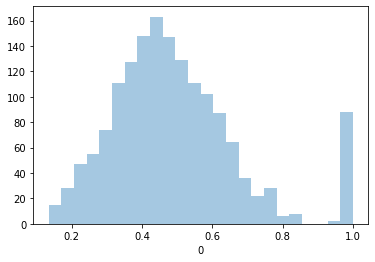

In [73]:
df = pd.DataFrame(cos_scores)
sns.distplot(df[0],kde=False)

In [55]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

embedder = SentenceTransformer("jhgan/ko-sbert-sts")

# Corpus with example sentences
corpus = ['한 남자가 음식을 먹는다.',
          '한 남자가 빵 한 조각을 먹는다.',
          '그 여자가 아이를 돌본다.',
          '한 남자가 말을 탄다.',
          '한 여자가 바이올린을 연주한다.',
          '두 남자가 수레를 숲 속으로 밀었다.',
          '한 남자가 담으로 싸인 땅에서 백마를 타고 있다.',
          '원숭이 한 마리가 드럼을 연주한다.',
          '치타 한 마리가 먹이 뒤에서 달리고 있다.']

corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)

# Query sentences:
queries = ['한 남자가 파스타를 먹는다.',
           '고릴라 의상을 입은 누군가가 드럼을 연주하고 있다.',
           '치타가 들판을 가로 질러 먹이를 쫓는다.']

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 5
for query in queries:
    query_embedding = embedder.encode(query, convert_to_tensor=True)
    cos_scores = util.pytorch_cos_sim(query_embedding, corpus_embeddings)[0]
    cos_scores = cos_scores.cpu()

    #We use np.argpartition, to only partially sort the top_k results
    top_results = np.argpartition(-cos_scores, range(top_k))[0:top_k]

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")

    for idx in top_results[0:top_k]:
        print(corpus[idx].strip(), "(Score: %.4f)" % (cos_scores[idx]))





Query: 한 남자가 파스타를 먹는다.

Top 5 most similar sentences in corpus:
한 남자가 음식을 먹는다. (Score: 0.6154)
한 남자가 빵 한 조각을 먹는다. (Score: 0.5451)
한 여자가 바이올린을 연주한다. (Score: 0.0980)
한 남자가 말을 탄다. (Score: 0.0686)
한 남자가 담으로 싸인 땅에서 백마를 타고 있다. (Score: 0.0572)




Query: 고릴라 의상을 입은 누군가가 드럼을 연주하고 있다.

Top 5 most similar sentences in corpus:
원숭이 한 마리가 드럼을 연주한다. (Score: 0.7253)
치타 한 마리가 먹이 뒤에서 달리고 있다. (Score: 0.1940)
한 여자가 바이올린을 연주한다. (Score: 0.1483)
한 남자가 담으로 싸인 땅에서 백마를 타고 있다. (Score: 0.0471)
한 남자가 음식을 먹는다. (Score: 0.0082)




Query: 치타가 들판을 가로 질러 먹이를 쫓는다.

Top 5 most similar sentences in corpus:
치타 한 마리가 먹이 뒤에서 달리고 있다. (Score: 0.7887)
원숭이 한 마리가 드럼을 연주한다. (Score: 0.3887)
두 남자가 수레를 숲 속으로 밀었다. (Score: 0.1610)
한 남자가 음식을 먹는다. (Score: 0.0739)
그 여자가 아이를 돌본다. (Score: 0.0568)
